Searching eigenvalues in range: 0.1 to 2
Trying initial guess: 0.224
Success: Found eigenvalue Omega^2 = 0.22412
Continuum spectrum diagnostic:


Legended[-Graphics-, Placed[LineLegend[{Directive[Opacity[1.], 
 
>       RGBColor[0.368417, 0.506779, 0.709798], AbsoluteThickness[1.6]], 
 
>      Directive[Opacity[1.], RGBColor[0.880722, 0.611041, 0.142051], 
 
>       AbsoluteThickness[1.6]]}, {Omega_a^2(x), Omega_G^2(x)}, LegendMarkers -> None, 
 
>     LabelStyle -> {}, LegendLayout -> Column], After, Identity]]
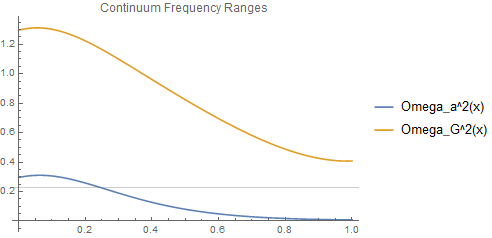

In [509]:
(* Global GAM Eigenvalue Solver (Enhanced Stability Version) *)
ClearAll["Global`*"];

(*=== Physical Parameters ===*)
a = 1.0;          
rho0 = 0.01;      
gammai = 5/3;     
tau = 1.0;        
xmatch = 0.8;      

(*=== Equilibrium Profiles ===*)
q[x_] := 1.2 + 3.8*x^2 + 0.1*Exp[-10*x];  (* Safety factor *)
T[x_] := 0.3 + 0.7*(1 - x^2)^2 + 0.1*x;   (* Temperature profile *)

(*=== Frequency Parameters ===*)
OmegaASq[x_] := T[x]/(2*q[x]^2);         (* Acoustic continuum frequency squared *)
OmegaGSq[x_] := T[x]*(1 + 1/(2*q[x]^2)); (* GAM continuum frequency squared *)

(*=== Dispersion Function ===*)
NumeratorDrd[OmegaSq_, x_] := (OmegaSq - OmegaASq[x])*(OmegaSq - OmegaGSq[x]);
DenominatorDrd[OmegaSq_, x_] := 2*(gammai + tau)*T[x]^2*OmegaSq + 10^-6;
Drd[OmegaSq_, x_] := NumeratorDrd[OmegaSq, x]/DenominatorDrd[OmegaSq, x];

(*=== Differential Equation System ===*)
eqnleft[OmegaSq_] := {
  E0r''[x] == (4/(rho0^2*T[x]))*Drd[OmegaSq, x]*E0r[x],
  E0r[0] == 0,        (* Left boundary condition *)
  E0r'[0] == 0.0001   (* Normalized initial derivative *)
};

eqnright[OmegaSq_] := {
    E0r''[x] == (4/(rho0^2*T[x]))*Drd[OmegaSq, x]*E0r[x],
    E0r[1] == 0,        (* Left boundary condition *)
    E0r'[1] == 1   (* Normalized initial derivative *)
}
(*=== Enhanced Shooting Method ===*)
ShootingMethod[OmegaSqGuess_] := Module[
  {solLeft, solRight, logderivLeft, logderivRight, eps = 10^-6},
  
  solLeft = Quiet@Check[
     NDSolve[eqnleft[OmegaSqGuess], E0r, {x, 0, xmatch}, 
      PrecisionGoal -> 10, AccuracyGoal -> 10,
      Method -> {"StiffnessSwitching", "NonstiffTest" -> False}],
     $Failed];
  
  solRight = Quiet@Check[
     NDSolve[eqnright[OmegaSqGuess],
      E0r, {x, xmatch, 1}, PrecisionGoal -> 10, AccuracyGoal -> 10,
      Method -> {"StiffnessSwitching", "NonstiffTest" -> False}],
     $Failed];
  
  If[solLeft === $Failed || solRight === $Failed, Return[10^6]];
  
  logderivLeft = (E0r'[xmatch]/(E0r[xmatch] + eps)) /. solLeft[[1]];
  logderivRight = (E0r'[xmatch]/(E0r[xmatch] + eps)) /. solRight[[1]];
  
  (logderivLeft - logderivRight) /; NumericQ[logderivLeft] && NumericQ[logderivRight]
];



(*=== Adaptive Parameter Search ===*)
OmegaSqStart = 0.224;
OmegaSqIni = 0.1;
OmegaSqEnd = 2;

Print["Searching eigenvalues in range: ", OmegaSqIni, " to ", OmegaSqEnd];

OmegaSqSolution = Catch[
    currentGuess = OmegaSqStart;
    Print["Trying initial guess: ", currentGuess];
    sol = Quiet@Check[
       OmegaSq /. FindRoot[
         ShootingMethod[OmegaSq], 
         {OmegaSq, currentGuess, OmegaSqIni, OmegaSqEnd},
         Method -> "Secant", Evaluated -> False, MaxIterations -> 50
       ],
       $Failed];
    
    If[NumericQ[sol], 
     Throw[sol];
     Break[];
    ]
];

(*=== Results Verification ===*)
If[NumericQ[OmegaSqSolution], 
  Print["Success: Found eigenvalue Omega^2 = ", OmegaSqSolution];
  FinalSolution = NDSolve[eqnleft[OmegaSqSolution], E0r, {x, 0, 1}, PrecisionGoal -> 10];
  Plot[E0r[x] /. FinalSolution[[1]], {x, 0, 1}, 
   PlotLabel -> Style["Global GAM Mode (Omega^2 = " <> ToString[NumberForm[OmegaSqSolution, {5, 3}]] <> ")", 14], 
   AxesLabel -> {"x", "E0r"}, ImageSize -> 500], 
  Print["No valid solution found, adjust parameters"]];

(*=== Continuum Visualization ===*)
Print["Continuum spectrum diagnostic:"];
Plot[{OmegaASq[x], OmegaGSq[x]}, {x, 0, 1}, 
 PlotLegends -> {"Omega_a^2(x)", "Omega_G^2(x)"}, 
 PlotLabel -> "Continuum Frequency Ranges", 
 GridLines -> {{}, {OmegaSqSolution}}]


Numerical precision maintained at 15.9546 digits
Eigenvalue solution: 0.224120


-Graphics-
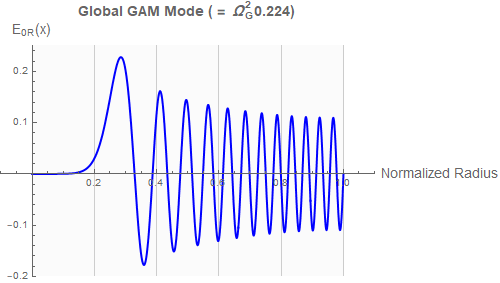

In [519]:
(* Corrected GAM mode visualization *)
Plot[E0r[x] /. FinalSolution[[1]], {x, 0, 1},
 PlotStyle -> {Thick, Blue},
 PlotLabel -> Style[Row[{"Global GAM Mode (", 
    Subscript[Style["Ω", Italic], "G"]^2 " = ", 
    NumberForm[OmegaSqSolution, {5, 3}], ")"}], 14, Bold],
 AxesLabel -> {
   Style["Normalized Radius", 14], 
Style[Row[{Subscript["E", "0R"], "(x)"}], 14]},  (* Fixed string concatenation *)
 ImageSize -> 500,
 GridLines -> {Automatic, {-1, 0, 1}},
 Prolog -> {LightGray, Opacity[0.1], Rectangle[{0, -1}, {1, 1}]},
 Epilog -> {
   Text[Style["Continuum Gap Region", 12], {0.5, 0.8}, Background -> White], 
   Arrow[{{0.6, 0.7}, {0.7, 0.3}}]
 },
 PlotRange -> {{-0.1, 1.1}, Automatic},
 PerformanceGoal -> "Quality",
 AspectRatio -> 1/GoldenRatio
]

(* Enhanced diagnostic output *)
Print["======================================"];
Print["Numerical precision maintained at ", $MachinePrecision, " digits"];
Print["Eigenvalue solution: ", NumberForm[OmegaSqSolution, {8, 6}]];

### omega^2=0.91

In [289]:
(* Global GAM Eigenvalue Solver (Enhanced Stability Version) *)
ClearAll["Global`*"];

(*=== Physical Parameters ===*)
a = 1.0;
rho0 = 0.01;
gammai = 5/3;
tau = 1.0;
xmatch = 0.8;

(*=== Adaptive Parameter Search ===*)
OmegaSqStart = 0.224;
OmegaSqIni = 0.1;
OmegaSqEnd = 2;

(*=== Equilibrium Profiles ===*)
q[x_] := 1.05 + 4*x^2;  (* Safety factor *)
T[x_] := 0.2 + 0.8*(1 - x^2)^2;   (* Temperature profile *)

(*=== Frequency Parameters ===*)
OmegaASq[x_] := T[x]/(2*q[x]^2);         (* Acoustic continuum frequency squared *)
OmegaGSq[x_] := T[x]*(1 + 1/(2*q[x]^2)); (* GAM continuum frequency squared *)

(*=== Dispersion Function ===*)
NumeratorDrd[OmegaSq_, x_] := (OmegaSq - OmegaASq[x])*(OmegaSq - OmegaGSq[x]);
DenominatorDrd[OmegaSq_, x_] := 2*(gammai + tau)*T[x]^2*OmegaSq + 10^-6;
Drd[OmegaSq_, x_] := NumeratorDrd[OmegaSq, x]/DenominatorDrd[OmegaSq, x];

(*=== Differential Equation System ===*)
eqnleft[OmegaSq_] := {
  E0r''[x] == (4/(rho0^2*T[x]))*Drd[OmegaSq, x]*E0r[x],
  E0r[0] == 0,        (* Left boundary condition *)
  E0r'[0] == 0.0001   (* Normalized initial derivative *)
};

eqnright[OmegaSq_] := {
    E0r''[x] == (4/(rho0^2*T[x]))*Drd[OmegaSq, x]*E0r[x],
    E0r[1] == 0,        (* Left boundary condition *)
    E0r'[1] == 1.0   (* Normalized initial derivative *)
};

(* eqn[OmegaSq_] := {
    E0r''[x] == (4/(rho0^2*T[x]))*Drd[OmegaSq, x]*E0r[x],
    E0r[0] == 0,        (* Left boundary condition *)
    (* E0r'[0] == 0.0001,   Normalized initial derivative *)
    E0r[1] == 0,        (* Left boundary condition *)
    (* E0r'[1] == 0.01   Normalized initial derivative *)
} *)
(*=== Enhanced Shooting Method ===*)
ShootingMethod[OmegaSqGuess_] := Module[
  {solLeft, solRight, logderivLeft, logderivRight, eps = 10^-6},
  
  solLeft = Quiet@Check[
     NDSolve[eqnleft[OmegaSqGuess], E0r, {x, 0, xmatch}, 
      PrecisionGoal -> 10, AccuracyGoal -> 10,
      Method -> {"StiffnessSwitching", "NonstiffTest" -> False}],
     $Failed];
  
  solRight = Quiet@Check[
     NDSolve[eqnright[OmegaSqGuess],
      E0r, {x, xmatch, 1}, PrecisionGoal -> 10, AccuracyGoal -> 10,
      Method -> {"StiffnessSwitching", "NonstiffTest" -> False}],
     $Failed];
  
  If[solLeft === $Failed || solRight === $Failed, Return[10^6]];
  
  logderivLeft = (E0r'[xmatch]/(E0r[xmatch] + eps)) /. solLeft[[1]];
  logderivRight = (E0r'[xmatch]/(E0r[xmatch] + eps)) /. solRight[[1]];
  
  (logderivLeft - logderivRight) /; NumericQ[logderivLeft] && NumericQ[logderivRight]
];


Print["Searching eigenvalues in range: ", OmegaSqIni, " to ", OmegaSqEnd];

OmegaSqSolution = Catch[
    currentGuess = OmegaSqStart;
    Print["Trying initial guess: ", currentGuess];
    sol = Quiet@Check[
       OmegaSq /. FindRoot[
         ShootingMethod[OmegaSq], 
         {OmegaSq, currentGuess, OmegaSqIni, OmegaSqEnd},
         Method -> "Secant", Evaluated -> False, MaxIterations -> 50
       ],
       $Failed];
    
    If[NumericQ[sol], 
     Throw[sol];
     Break[];
    ]
];


(*=== Unified Solution Handling ===*)
If[NumericQ[OmegaSqSolution],
  Print["Success: Found eigenvalue Omega^2 = ", OmegaSqSolution];
  
  (* Final solution computation *)
  solLeftFinal = NDSolve[eqnleft[OmegaSqSolution], E0r, {x, 0, xmatch}, 
    PrecisionGoal -> 10, Method -> "StiffnessSwitching"];
  
  solRightFinal = NDSolve[eqnright[OmegaSqSolution], E0r, {x, xmatch, 1}, 
    PrecisionGoal -> 10, Method -> "StiffnessSwitching"];

  (* Boundary derivative verification *)
  finalDifference = ShootingMethod[OmegaSqSolution];
  Print["Final boundary derivative difference: ", 
        ScientificForm[finalDifference, 3]];
];


(*==== Fixed Exact Grid Data Export Module ====*)
ExportGAMDataExactFixed[filename_String, leftSol_, rightSol_, xmatch_, totalPoints_:1000] := Module[
  {nLeft, nRight, leftStep, rightStep, leftData, rightData, header},
  
  (* Dynamic point calculation *)
  nLeft = Max[Floor[xmatch*totalPoints], 1];
  nRight = Max[Floor[(1 - xmatch)*totalPoints], 1];
  
  (* Step size correction *)
  leftStep = If[nLeft > 1, xmatch/(nLeft - 1), 0]; (* Ensure endpoint inclusion *)
  rightStep = If[nRight > 1, (1 - xmatch)/(nRight - 1), 0];
  
  (* Left domain generation *)
  leftData = If[nLeft > 0,
    Table[
      {x, Re[E0r[x] /. leftSol[[1]]], Im[E0r[x] /. leftSol[[1]]]},
      {x, 0, xmatch, leftStep}
    ],
    {}
  ];
  
  (* Corrected right domain generation *)
  rightData = If[nRight > 0,
    Table[
      {x, Re[E0r[x] /. rightSol[[1]]], Im[E0r[x] /. rightSol[[1]]]},
      {x, xmatch, 1, rightStep}
    ][[2;;]], (* Exclude xmatch to avoid duplication *)
    {}
  ];
  
  (* Data validation *)
  If[Length[leftData] > 0 && leftData[[-1, 1]] != xmatch, 
     AppendTo[leftData, {xmatch, Re[E0r[xmatch] /. leftSol[[1]]], Im[E0r[xmatch] /. leftSol[[1]]]}]];

  (* Unified export *)
  header = {"x", "Re[Er]", "Im[Er]"};
  Export[filename, Join[{header}, leftData, rightData], "CSV"];
  
  Print["Exported " <> ToString[Length[leftData] + Length[rightData]] <> 
        " points (Left:" <> ToString[nLeft] <> " Right:" <> ToString[nRight] <> ")"]
];

(* Execute corrected export *)
If[NumericQ[OmegaSqSolution] && Head[solLeftFinal] === List && Head[solRightFinal] === List,
  ExportGAMDataExactFixed["GAM_exact_data.csv", solLeftFinal, solRightFinal, xmatch];
  Print["Export successful → GAM_exact_data.csv"],
  Print["Export failed: Incomplete solution"]
];


Searching eigenvalues in range: 0.1 to 2
Trying initial guess: 0.224
Success: Found eigenvalue Omega^2 = 0.307011
                                               -8
Final boundary derivative difference: 1.71 x 10
Exported 998 points (Left:800 Right:199)
Export successful -> GAM_exact_data.csv


In [ ]:
(* Global GAM Eigenvalue Solver (Enhanced Stability Version) *)
ClearAll["Global`*"];

(*=== Physical Parameters ===*)
a = 1.0;
rho0 = 0.01;
gammai = 5/3;
tau = 1.0;
xmatch = 0.3;

(*=== Adaptive Parameter Search ===*)
OmegaSqStart = 0.224;
OmegaSqIni = 0.1;
OmegaSqEnd = 2;

(*=== Equilibrium Profiles ===*)
q[x_] := 1.05 + 4*x^2;  (* Safety factor *)
T[x_] := 0.2 + 0.8*(1 - x^2)^2;   (* Temperature profile *)

(*=== Frequency Parameters ===*)
OmegaASq[x_] := T[x]/(2*q[x]^2);         (* Acoustic continuum frequency squared *)
OmegaGSq[x_] := T[x]*(1 + 1/(2*q[x]^2)); (* GAM continuum frequency squared *)

(*=== Dispersion Function ===*)
NumeratorDrd[OmegaSq_, x_] := (OmegaSq - OmegaASq[x])*(OmegaSq - OmegaGSq[x]);
DenominatorDrd[OmegaSq_, x_] := 2*(gammai + tau)*T[x]^2*OmegaSq + 10^-6;
Drd[OmegaSq_, x_] := NumeratorDrd[OmegaSq, x]/DenominatorDrd[OmegaSq, x];

(*=== Differential Equation System ===*)
eqnleft[OmegaSq_] := {
  E0r''[x] == (4/(rho0^2*T[x]))*Drd[OmegaSq, x]*E0r[x],
  E0r[0] == 0,        (* Left boundary condition *)
  E0r'[0] == 0.0001   (* Normalized initial derivative *)
};

eqnright[OmegaSq_] := {
    E0r''[x] == (4/(rho0^2*T[x]))*Drd[OmegaSq, x]*E0r[x],
    E0r[1] == 0,        (* Left boundary condition *)
    E0r'[1] == 0.01   (* Normalized initial derivative *)
};

(* eqn[OmegaSq_] := {
    E0r''[x] == (4/(rho0^2*T[x]))*Drd[OmegaSq, x]*E0r[x],
    E0r[0] == 0,        (* Left boundary condition *)
    (* E0r'[0] == 0.0001,   Normalized initial derivative *)
    E0r[1] == 0,        (* Left boundary condition *)
    (* E0r'[1] == 0.01   Normalized initial derivative *)
} *)
(*=== Enhanced Shooting Method ===*)
ShootingMethod[OmegaSqGuess_] := Module[
  {solLeft, solRight, logderivLeft, logderivRight, eps = 10^-6},
  
  solLeft = Quiet@Check[
     NDSolve[eqnleft[OmegaSqGuess], E0r, {x, 0, xmatch}, 
      PrecisionGoal -> 10, AccuracyGoal -> 10,
      Method -> {"StiffnessSwitching", "NonstiffTest" -> False}],
     $Failed];
  
  solRight = Quiet@Check[
     NDSolve[eqnright[OmegaSqGuess],
      E0r, {x, xmatch, 1}, PrecisionGoal -> 10, AccuracyGoal -> 10,
      Method -> {"StiffnessSwitching", "NonstiffTest" -> False}],
     $Failed];
  
  If[solLeft === $Failed || solRight === $Failed, Return[10^6]];
  
  logderivLeft = (E0r'[xmatch]/(E0r[xmatch] + eps)) /. solLeft[[1]];
  logderivRight = (E0r'[xmatch]/(E0r[xmatch] + eps)) /. solRight[[1]];
  
  (logderivLeft - logderivRight) /; NumericQ[logderivLeft] && NumericQ[logderivRight]
];


Print["Searching eigenvalues in range: ", OmegaSqIni, " to ", OmegaSqEnd];

OmegaSqSolution = Catch[
    currentGuess = OmegaSqStart;
    Print["Trying initial guess: ", currentGuess];
    sol = Quiet@Check[
       OmegaSq /. FindRoot[
         ShootingMethod[OmegaSq], 
         {OmegaSq, currentGuess, OmegaSqIni, OmegaSqEnd},
         Method -> "Secant", Evaluated -> False, MaxIterations -> 50
       ],
       $Failed];
    
    If[NumericQ[sol], 
     Throw[sol];
     Break[];
    ]
];


(*=== Unified Solution Handling ===*)
If[NumericQ[OmegaSqSolution],
  Print["Success: Found eigenvalue Omega^2 = ", OmegaSqSolution];
  
  (* Final solution computation *)
  solLeftFinal = NDSolve[eqnleft[OmegaSqSolution], E0r, {x, 0, xmatch}, 
    PrecisionGoal -> 10, Method -> "StiffnessSwitching"];
  
  solRightFinal = NDSolve[eqnright[OmegaSqSolution], E0r, {x, xmatch, 1}, 
    PrecisionGoal -> 10, Method -> "StiffnessSwitching"];

  (* Boundary derivative verification *)
  finalDifference = ShootingMethod[OmegaSqSolution];
  Print["Final boundary derivative difference: ", 
        ScientificForm[finalDifference, 3]];
];


(*==== Fixed Exact Grid Data Export Module ====*)
ExportGAMDataExactFixed[filename_String, leftSol_, rightSol_, xmatch_, totalPoints_:1000] := Module[
  {nLeft, nRight, leftStep, rightStep, leftData, rightData, header},
  
  (* Dynamic point calculation *)
  nLeft = Max[Floor[xmatch*totalPoints], 1];
  nRight = Max[Floor[(1 - xmatch)*totalPoints], 1];
  
  (* Step size correction *)
  leftStep = If[nLeft > 1, xmatch/(nLeft - 1), 0]; (* Ensure endpoint inclusion *)
  rightStep = If[nRight > 1, (1 - xmatch)/(nRight - 1), 0];
  
  (* Left domain generation *)
  leftData = If[nLeft > 0,
    Table[
      {x, Re[E0r[x] /. leftSol[[1]]], Im[E0r[x] /. leftSol[[1]]]},
      {x, 0, xmatch, leftStep}
    ],
    {}
  ];
  
  (* Corrected right domain generation *)
  rightData = If[nRight > 0,
    Table[
      {x, Re[E0r[x] /. rightSol[[1]]], Im[E0r[x] /. rightSol[[1]]]},
      {x, xmatch, 1, rightStep}
    ][[2;;]], (* Exclude xmatch to avoid duplication *)
    {}
  ];
  
  (* Data validation *)
  If[Length[leftData] > 0 && leftData[[-1, 1]] != xmatch, 
     AppendTo[leftData, {xmatch, Re[E0r[xmatch] /. leftSol[[1]]], Im[E0r[xmatch] /. leftSol[[1]]]}]];

  (* Unified export *)
  header = {"x", "Re[Er]", "Im[Er]"};
  Export[filename, Join[{header}, leftData, rightData], "CSV"];
  
  Print["Exported " <> ToString[Length[leftData] + Length[rightData]] <> 
        " points (Left:" <> ToString[nLeft] <> " Right:" <> ToString[nRight] <> ")"]
];

(* Execute corrected export *)
If[NumericQ[OmegaSqSolution] && Head[solLeftFinal] === List && Head[solRightFinal] === List,
  ExportGAMDataExactFixed["GAM_exact_data.csv", solLeftFinal, solRightFinal, xmatch];
  Print["Export successful → GAM_exact_data.csv"],
  Print["Export failed: Incomplete solution"]
];
